This notebook uses a new version of NaMaster (respect to the previous notebooks)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from scipy import stats
import common as co
import healpy as hp
import numpy as np
import pymaster as nmt
import os

In [3]:
prefix =  'run_sph_2b'
run_path = os.path.join('./simulations_outputs/', prefix, prefix)
figures_dir = os.path.join('./simulations_outputs/', prefix, 'figures_1stbin')
if not os.path.isdir(figures_dir):
    os.makedirs(figures_dir)
fig_run_path = os.path.join(figures_dir, prefix)
data_folder = './data/'
sims_suffix = '_cl_0001-20000.npz'
nside=512 # I think it can be read from somewhere

# Common

## Load theoretical data and sampled data

In [4]:
ell_cl2bins_file = np.load('./data/cls_lss_2bins.npz')
lTh, cl2bins, nl2bins = ell_cl2bins_file['ls'], ell_cl2bins_file['cls'], ell_cl2bins_file['nls']

cl2bins_1 = (cl2bins + nl2bins)[:3, :3]
cl2bins_2 = (cl2bins + nl2bins)[3:, 3:]
i, j = np.triu_indices(3)

clTh_TT = cl2bins_1[0, 0]
clTh_EE = cl2bins_1[1, 1]
clTh_BB = cl2bins_1[2, 2]
clTh_TE = cl2bins_1[0, 1]
clTh_TB = clTh_EB = cl2bins_1[0, 2]

Check script: compare th cl's computed with original ones.

In [5]:
mask_lss=hp.ud_grade(hp.read_map(os.path.join(data_folder, 'mask_lss_sph1.fits'),verbose=False),nside_out=nside) 
fsky=np.mean(mask_lss)
d_ell=int(1./fsky)
b=nmt.NmtBin(nside,nlb=d_ell)  # Used later for Naive cov.

In [6]:
def get_fields(w_cont=False) :
    """
    Generate a simulated field.
    It returns two NmtField objects for a spin-0 and a spin-2 field.

    :param fsk: a fm.FlatMapInfo object.
    :param mask: a sky mask.
    :param w_cont: deproject any contaminants? (not implemented yet)
    """
    st,sq,su=hp.synfast([clTh_TT,clTh_EE,clTh_BB, clTh_TE],nside,new=True,verbose=False,pol=True)
    if w_cont:
        if np.any(templates_all):
            tst, tsq, tsu = templates_all.sum(axis=0)
            st+=tst; sq+=tsq; su+=tsu;

        if o.no_deproject:
            ff0 = nmt.NmtField(mask_lss, [st])
            ff2 = nmt.NmtField(mask_lss, [sq, su])
        else:
            ff0 = nmt.NmtField(mask_lss, [st], templates_all[:, 0, None, :])
            ff2 = nmt.NmtField(mask_lss, [sq, su], templates_all[:, 1:, :])
    else :
        ff0=nmt.NmtField(mask_lss,[st])
        ff2=nmt.NmtField(mask_lss,[sq,su])
    return ff0,ff2

np.random.seed(1000)
f0,f2=get_fields()

### Simulations correlations

In [7]:
if not os.path.isfile(run_path + '_b1' + sims_suffix):
    clsims = np.load(run_path + sims_suffix)['arr_0']
    mat = np.empty((6, 6, clsims.shape[1], clsims.shape[2]))
    i, j = np.triu_indices(6)
    mat[i, j] = clsims
    mat[j, i] = clsims
    clsims = mat[:3, :3]
    mat = 0
    np.savez_compressed(run_path + '_b1' + sims_suffix, clsims)
else:
    clsims = np.load(run_path + '_b1' + sims_suffix)['arr_0']

In [8]:
clTT = cl00 = clsims[0, 0]
clEE = clsims[1, 1]
clBB = clsims[2, 2]
clTE = clsims[0, 1]
clTB = clsims[0, 2]
clEB = clsims[1, 2]

nlbins = b.get_n_bands()
lbins = b.get_effective_ells()

In [9]:
clTT.shape

(20000, 511)

Healpix has bins of same area but its integrals are not completely exact. Sometimes the best we can do is up to (2 x nbins)

In [10]:
lmax = (lbins < 2*512).sum()

In [11]:
CovSims_path = run_path + '_cov_b1'+sims_suffix
if os.path.isfile(CovSims_path):
    C = np.load(CovSims_path)['arr_0']
else:
    C = np.cov(np.concatenate([clTT.T, clTE.T, clTB.T, clEE.T, clEB.T, clBB.T]))
    np.savez_compressed(CovSims_path, C)
C = C.reshape((6, nlbins, 6, nlbins))

In [12]:
CovSims_TT = C[0, :, 0, :]
CovSims_TE = C[1, :, 1, :]
CovSims_TB = C[2, :, 2, :]
CovSims_EE = C[3, :, 3, :]
CovSims_EB = C[4, :, 4, :]
CovSims_BB = C[5, :, 5, :]

CovSims_TTTE = C[0, :, 1, :]
CovSims_TTTB = C[0, :, 2, :]
CovSims_TTEE = C[0, :, 3, :]
CovSims_TTEB = C[0, :, 4, :]
CovSims_TTBB = C[0, :, 4, :]

CovSims_TETB = C[1, :, 2, :]
CovSims_TEEE = C[1, :, 3, :]
CovSims_TEEB = C[1, :, 4, :]
CovSims_TEBB = C[1, :, 5, :]

CovSims_TBEE = C[2, :, 3, :]
CovSims_TBEB = C[2, :, 4, :]
CovSims_TBBB = C[2, :, 5, :]

CovSims_EEEB = C[3, :, 4, :]
CovSims_EEBB = C[3, :, 5, :]

CovSims_EBBB = C[4, :, 5, :]

if os.path.isfile(run_path + '_covTTTEEE_b1'+sims_suffix):
    CovSims_TTTEEE = np.load(run_path + '_covTTTEEE_b1'+sims_suffix)['arr_0']
else:
    CovSims_TTTEEE = np.block([[CovSims_TT, CovSims_TTTE, CovSims_TTEE], 
                               [CovSims_TTTE.T, CovSims_TE, CovSims_TEEE], 
                               [CovSims_TTEE.T, CovSims_TEEE.T, CovSims_EE]])
    np.savez_compressed(run_path + '_covTTTEEE_b1'+sims_suffix, CovSims_TTTEEE)

### Analytic Covariances

In [13]:
w00 = nmt.NmtWorkspace()
w00.read_from(run_path + "_w00_11.dat")
w02 = nmt.NmtWorkspace()
w02.read_from(run_path + "_w02_11.dat")
w22 = nmt.NmtWorkspace()
w22.read_from(run_path + "_w22_11.dat")

We don't need to create a different covariance workspace for each spin combination because it only depends on the masks of the field

In [14]:
cw = nmt.NmtCovarianceWorkspace()
#cw02 = nmt.NmtCovarianceWorkspace()
#cw22 = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f0, f0)
#cw02.compute_coupling_coefficients(f0, f2)
#cw22.compute_coupling_coefficients(f2, f2)

#### Approx Efstathiou

In [15]:
cltt = clTh_TT
clte = clTh_TE
clee = clTh_EE
clbb = clTh_BB

if os.path.isfile(run_path+'_c0000_b1.npz'):
    c0000 = np.load(run_path+'_c0000_b1.npz')['arr_0']
else:
    c0000=nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[cltt],[cltt],[cltt],w00); print(c0000.shape)
    np.savez_compressed(run_path+'_c0000_b1.npz', c0000)
    
if os.path.isfile(run_path+'_c0002_b1.npz'):
    c0002 = np.load(run_path+'_c0002_b1.npz')['arr_0']
else:
    c0002=nmt.gaussian_covariance(cw,0,0,0,2,[cltt],[clte,0*clte],[cltt],[clte,0*clte],w00,w02).reshape((nlbins, 1, nlbins, 2)); print(c0002.shape)
    np.savez_compressed(run_path+'_c0002_b1.npz', c0002)
    
if os.path.isfile(run_path+'_c0022_b1.npz'):
    c0022 = np.load(run_path+'_c0022_b1.npz')['arr_0']
else:
    c0022=nmt.gaussian_covariance(cw,0,0,2,2,[clte,0*clte],[clte,0*clte],[clte,0*clte],[clte,0*clte],w00,w22).reshape((nlbins, 1, nlbins, 4)); print(c0022.shape)
    np.savez_compressed(run_path+'_c0022_b1.npz', c0022)
    
if os.path.isfile(run_path+'_c0202_b1.npz'):
    c0202 = np.load(run_path+'_c0202_b1.npz')['arr_0']
else:
    c0202=nmt.gaussian_covariance(cw,0,2,0,2,[cltt],[clte,0*clte],[clte,0*clte],[clee,0*clee,0*clbb,clbb],w02,w02).reshape((nlbins, 2, nlbins, 2)); print(c0202.shape)
    np.savez_compressed(run_path+'_c0202_b1.npz', c0202)
    
if os.path.isfile(run_path+'_c0222_b1.npz'):
    c0222 = np.load(run_path+'_c0222_b1.npz')['arr_0']
else:
    c0222=nmt.gaussian_covariance(cw,0,2,2,2,[clte,0*clte],[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],w02,w22).reshape((nlbins, 2, nlbins, 4)); print(c0222.shape)
    np.savez_compressed(run_path+'_c0222_b1.npz', c0222)
    
if os.path.isfile(run_path+'_c2222_b1.npz'):
    c2222 = np.load(run_path+'_c2222_b1.npz')['arr_0']
else:
    c2222=nmt.gaussian_covariance(cw,2,2,2,2,[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],w22,w22).reshape((nlbins, 4, nlbins, 4)); print(c2222.shape)
    np.savez_compressed(run_path+'_c2222_b1.npz', c2222)
    
    
# c0020=nmt.gaussian_covariance(cw,0,0,2,0,[clte,0*clte],[cltt],[clte,0*clte],[cltt],w00,w02); print(c0020.shape)
#c0200=nmt.gaussian_covariance(cw,0,2,0,0,[cltt],[cltt],[clte,0*clte],[clte,0*clte],w02,w00); print(c0200.shape)
#c0220=nmt.gaussian_covariance(cw,0,2,2,0,[clte,0*clte],[cltt],[clee,0*clee,0*clbb,clbb],[clte,0*clte],w02,w02); print(c0220.shape)
#c2000=nmt.gaussian_covariance(cw,2,0,0,0,[clte,0*clte],[clte,0*clte],[cltt],[cltt],w02,w00); print(c2000.shape)
#c2002=nmt.gaussian_covariance(cw,2,0,0,2,[clte,0*clte],[clee,0*clee,0*clbb,clbb],[cltt],[clte,0*clte],w02,w02); print(c2002.shape)
#c2020=nmt.gaussian_covariance(cw,2,0,2,0,[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clte,0*clte],[cltt],w02,w02); print(c2020.shape)
#c2022=nmt.gaussian_covariance(cw,2,0,2,2,[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clte,0*clte],w02,w22); print(c2022.shape)
#c2200=nmt.gaussian_covariance(cw,2,2,0,0,[clte,0*clte],[clte,0*clte],[clte,0*clte],[clte,0*clte],w22,w00); print(c2200.shape)
#c2202=nmt.gaussian_covariance(cw,2,2,0,2,[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clee,0*clee,0*clbb,clbb],w22,w02); print(c2202.shape)
#c2220=nmt.gaussian_covariance(cw,2,2,2,0,[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clte,0*clte],w22,w02); print(c2220.shape)

CovTh_TT = c0000
CovTh_TTTE, CovTh_TTTB = c0002[:, 0, :, [0, 1]]
CovTh_TTEE, CovTh_TTEB, CovTh_TTBE, CovTh_TTBB = c0022[:, 0, :, [0, 1, 2, 3]]
CovTh_TETE, CovTh_TETB = c0202[:, 0, :, [0, 1] ]
CovTh_TBTE, CovTh_TBTB = c0202[:, 1, :, [0, 1] ]
CovTh_TEEE, CovTh_TEEB, CovTh_TEBE, CovTh_TEBB =  c0222[:, 0, :, [0, 1, 2, 3] ]
CovTh_TBEE, CovTh_TBEB, CovTh_TBBE, CovTh_TBBB = c0222[:, 1, :, [0, 1, 2, 3] ]
CovTh_EEEE, CovTh_EEEB, CovTh_EEBE, CovTh_EEBB = c2222[:, 0, :, [0, 1, 2, 3] ]
CovTh_EBEE, CovTh_EBEB, CovTh_EBBE, CovTh_EBBB = c2222[:, 1, :, [0, 1, 2, 3] ]
CovTh_BEEE, CovTh_BEEB, CovTh_BEBE, CovTh_BEBB = c2222[:, 2, :, [0, 1, 2, 3] ]
CovTh_BBEE, CovTh_BBEB, CovTh_BBBE, CovTh_BBBB = c2222[:, 3, :, [0, 1, 2, 3] ]

CovTh_TE = CovTh_TETE
CovTh_TB = CovTh_TBTB
CovTh_EE = CovTh_EEEE
CovTh_EB = CovTh_EBEB
CovTh_BB = CovTh_BBBB

if os.path.isfile(run_path + '_covThTTTEEE_b1.npz'):
    CovTh_TTTEEE = np.load(run_path + '_covThTTTEEE_b1.npz')['arr_0']
else:
    CovTh_TTTEEE = np.block([[CovTh_TT, CovTh_TTTE, CovTh_TTEE], 
                               [CovTh_TTTE.T, CovTh_TE, CovTh_TEEE], 
                               [CovTh_TTEE.T, CovTh_TEEE.T, CovTh_EE]])
    np.savez_compressed(run_path + '_covThTTTEEE_b1.npz', CovTh_TTTEEE)

#### Spin 2 ~ Spin 0

In [16]:
cltt = clTh_TT
clte = clTh_TE
cltb = clbe = 0 * cltt
clee = clTh_EE
cleb = clbe = 0 * clee
clbb = clTh_BB

CovTh0_TT = CovTh_TT
CovTh0_TE = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[clte],[clte],[clee],w00)
CovTh0_TB = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[cltb],[cltb],[clbb],w00)
CovTh0_EE = nmt.gaussian_covariance(cw,0,0,0,0,[clee],[clee],[clee],[clee],w00)
CovTh0_EB = nmt.gaussian_covariance(cw,0,0,0,0,[clee],[cleb],[cleb],[clbb],w00)
CovTh0_BB = nmt.gaussian_covariance(cw,0,0,0,0,[clbb],[clbb],[clbb],[clbb],w00)

CovTh0_TTTE = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[clte],[cltt],[clte],w00)
CovTh0_TTTB = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[cltb],[cltt],[cltb],w00)
CovTh0_TTEE = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[clte],[clte],[clte],w00)
CovTh0_TTEB = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[cltb],[clte],[cltb],w00)
CovTh0_TTBB = nmt.gaussian_covariance(cw,0,0,0,0,[cltb],[cltb],[cltb],[cltb],w00)

CovTh0_TETB = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[cltb],[clte],[cleb],w00)
CovTh0_TEEE = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[clte],[clee],[clee],w00)
CovTh0_TEEB = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[cltb],[clee],[cleb],w00)
CovTh0_TEBB = nmt.gaussian_covariance(cw,0,0,0,0,[cltb],[cltb],[cleb],[cleb],w00)

CovTh0_TBEE = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[clte],[clbe],[clbe],w00)
CovTh0_TBEB = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[cltb],[clbe],[clbb],w00)
CovTh0_TBBB = nmt.gaussian_covariance(cw,0,0,0,0,[cltb],[cltb],[clbb],[clbb],w00)

CovTh0_EEEB = nmt.gaussian_covariance(cw,0,0,0,0,[clee],[cleb],[clee],[cleb],w00)
CovTh0_EEBB = nmt.gaussian_covariance(cw,0,0,0,0,[cleb],[cleb],[cleb],[cleb],w00)

CovTh0_EBBB = nmt.gaussian_covariance(cw,0,0,0,0,[cleb],[clbb],[cleb],[clbb],w00)

if not os.path.isfile(run_path + '_covSpin0_ar_b1.npz'):
    CTh0_ar = np.array([CovTh0_TT, CovTh0_TTTE, CovTh0_TTTB, CovTh0_TTEE, CovTh0_TTEB, CovTh0_TTBB,
                                 CovTh0_TE, CovTh0_TETB, CovTh0_TEEE, CovTh0_TEEB, CovTh0_TEBB,
                                             CovTh0_TB, CovTh0_TBEE, CovTh0_TBEB, CovTh0_TBBB,
                                                         CovTh0_EE, CovTh0_EEEB, CovTh0_EEBB,
                                                                     CovTh0_EB, CovTh0_EBBB,
                                                                                 CovTh0_BB])
    np.savez_compressed(run_path + '_covSpin0_ar_b1.npz', CTh0_ar)

#### Naive approx

In [17]:
l0=b.get_effective_ells()-d_ell/2
lf=b.get_effective_ells()+d_ell/2

cltt = clTh_TT
clte = clTh_TE
clee = clTh_EE
clbb = clTh_BB
cltt = clTh_TT
clte = clTh_TE
cltb = clbe = 0 * cltt
clee = clTh_EE
cleb = clbe = 0 * clee
clbb = clTh_BB

CovThN_TT = co.naive_covariance(lTh, l0, lf, fsky, clTh_TT, clTh_TT, clTh_TT, clTh_TT)
CovThN_TE = co.naive_covariance(lTh, l0, lf, fsky, clTh_TT, clTh_TE, clTh_TE, clTh_EE)
CovThN_TB = co.naive_covariance(lTh, l0, lf, fsky, clTh_TT, clTh_TB, clTh_TB, clTh_BB)
CovThN_EE = co.naive_covariance(lTh, l0, lf, fsky, clTh_EE, clTh_EE, clTh_EE, clTh_EE)
CovThN_EB = co.naive_covariance(lTh, l0, lf, fsky, clTh_EE, clTh_EB, clTh_EB, clTh_BB)
CovThN_BB = co.naive_covariance(lTh, l0, lf, fsky, clTh_BB, clTh_BB, clTh_BB, clTh_BB)

CovThN_TTTE = co.naive_covariance(lTh, l0, lf, fsky, cltt, clte, cltt, clte)
CovThN_TTTB = co.naive_covariance(lTh, l0, lf, fsky, cltt, cltb, cltt, cltb)
CovThN_TTEE = co.naive_covariance(lTh, l0, lf, fsky, clte, clte, clte, clte)
CovThN_TTEB = co.naive_covariance(lTh, l0, lf, fsky, clte, cltb, clte, cltb)
CovThN_TTBB = co.naive_covariance(lTh, l0, lf, fsky, cltb, cltb, cltb, cltb)

CovThN_TETB = co.naive_covariance(lTh, l0, lf, fsky, cltt, cltb, clte, cleb)
CovThN_TEEE = co.naive_covariance(lTh, l0, lf, fsky, clte, clte, clee, clee)
CovThN_TEEB = co.naive_covariance(lTh, l0, lf, fsky, clte, cltb, clee, cleb)
CovThN_TEBB = co.naive_covariance(lTh, l0, lf, fsky, cltb, cltb, cleb, cleb)

CovThN_TBEE = co.naive_covariance(lTh, l0, lf, fsky, clte, clte, clbe, clbe)
CovThN_TBEB = co.naive_covariance(lTh, l0, lf, fsky, clte, cltb, clbe, clbb)
CovThN_TBBB = co.naive_covariance(lTh, l0, lf, fsky, cltb, cltb, clbb, clbb)

CovThN_EEEB = co.naive_covariance(lTh, l0, lf, fsky, clee, cleb, clee, cleb)
CovThN_EEBB = co.naive_covariance(lTh, l0, lf, fsky, cleb, cleb, cleb, cleb)

CovThN_EBBB = co.naive_covariance(lTh, l0, lf, fsky, cleb, clbb, cleb, clbb)


if not os.path.isfile(run_path + '_covNaive_ar_b1.npz'):
    CthN_ar = np.array([CovThN_TT, CovThN_TTTE, CovThN_TTTB, CovThN_TTEE, CovThN_TTEB, CovThN_TTBB,
                                 CovThN_TE, CovThN_TETB, CovThN_TEEE, CovThN_TEEB, CovThN_TEBB,
                                             CovThN_TB, CovThN_TBEE, CovThN_TBEB, CovThN_TBBB,
                                                         CovThN_EE, CovThN_EEEB, CovThN_EEBB,
                                                                     CovThN_EB, CovThN_EBBB,
                                                                                 CovThN_BB])
    np.savez_compressed(run_path + '_covNaive_ar_b1.npz', CthN_ar)

# Efstathiou approximation

In [18]:
foutput = fig_run_path + '_Efstathiou'

## TTTT

Checks for TTTT
Diagonal covariance matrix


Chi2 distribution check


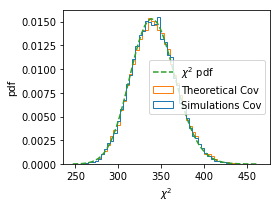

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.012700000000000045, pvalue=0.07882447996853424)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0034251700043310684, pvalue=0.9730599035908839)
KS between th. and chi2 distributions:  KstestResult(statistic=0.01135294882084481, pvalue=0.011534290607229467)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.008228460890405187, pvalue=0.13326019883263776)

Difference between analytic and sims. correlation matrix


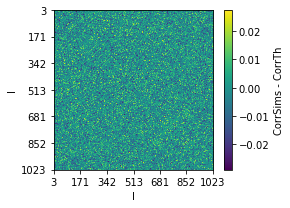

Eigenvalues vs l


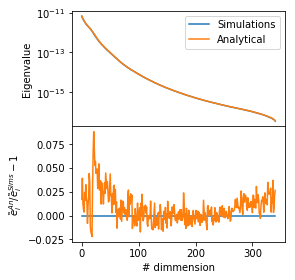

Row of cov. matrix.


In [19]:
chi2_TTTT, corr_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovTh_TT[:lmax, :lmax],
                                        modes="TTTT", foutput=foutput + '_TTTT')

## TETE

Checks for TETE
Diagonal covariance matrix


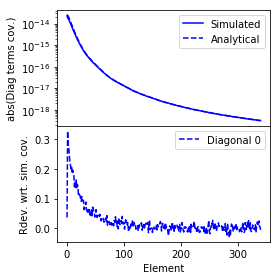

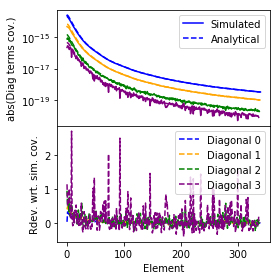

Chi2 distribution check


KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.10175000000000001, pvalue=1.437275838151738e-90)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0037126622554555233, pvalue=0.9456310665942268)
KS between th. and chi2 distributions:  KstestResult(statistic=0.10331201115416344, pvalue=7.683756296786744e-186)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.003415508131070985, pvalue=0.9737766316642829)

Difference between analytic and sims. correlation matrix


Eigenvalues vs l


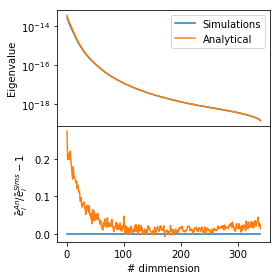

Row of cov. matrix.


In [20]:
chi2_TETE, corr_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovTh_TETE[:lmax, :lmax],
                                        modes="TETE", foutput=foutput + '_TETE')

## EEEE

Checks for EEEE
Diagonal covariance matrix


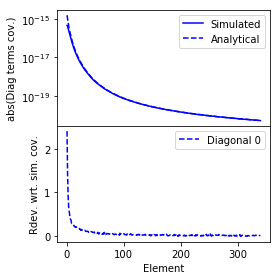

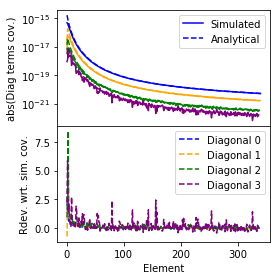

Chi2 distribution check


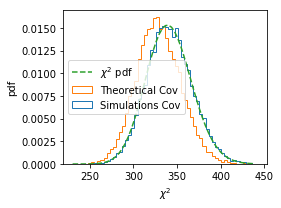

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.18985000000000002, pvalue=2.996470853e-314)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006154739083174987, pvalue=0.43485208807263914)
KS between th. and chi2 distributions:  KstestResult(statistic=0.1928471763988242, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.010797452332573787, pvalue=0.0188686637771891)

Difference between analytic and sims. correlation matrix


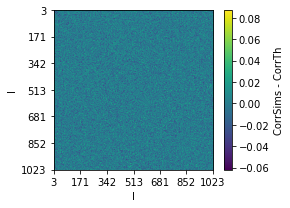

Eigenvalues vs l


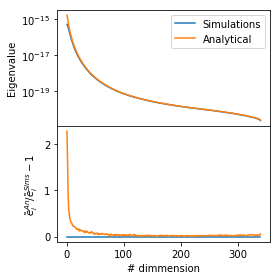

Row of cov. matrix.


In [21]:
chi2_EEEE, corr_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovTh_EEEE[:lmax, :lmax],
                                        modes="EEEE", foutput=foutput + '_EEEE')

## BBBB

Checks for BBBB
Diagonal covariance matrix


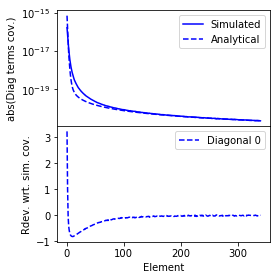

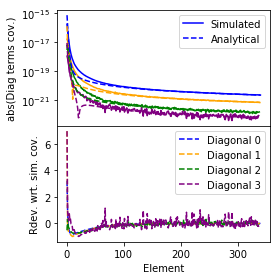

Chi2 distribution check


KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.8804000000000001, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004675605849221831, pvalue=0.7744163258682204)
KS between th. and chi2 distributions:  KstestResult(statistic=0.8826864395276753, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006072536054161359, pvalue=0.45206990172287326)

Difference between analytic and sims. correlation matrix


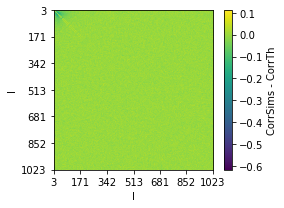

Eigenvalues vs l


Row of cov. matrix.


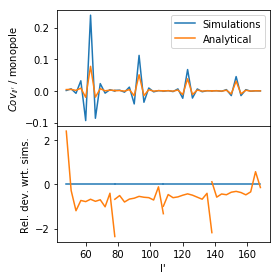

In [22]:
chi2_BBBB, corr_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovTh_BBBB[:lmax, :lmax],
                                        modes="BBBB", foutput=foutput + '_BBBB')

## TBTB

Checks for TBTB
Diagonal covariance matrix


Chi2 distribution check


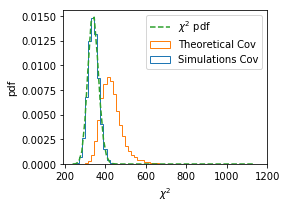

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.7878000000000001, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004246749950455098, pvalue=0.8635123463492754)
KS between th. and chi2 distributions:  KstestResult(statistic=0.7851648896254073, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006588483621867591, pvalue=0.35040739181649033)

Difference between analytic and sims. correlation matrix


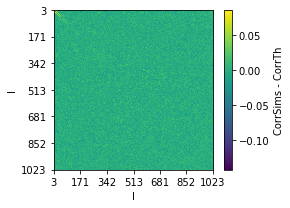

Eigenvalues vs l


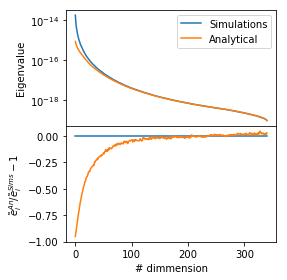

Row of cov. matrix.


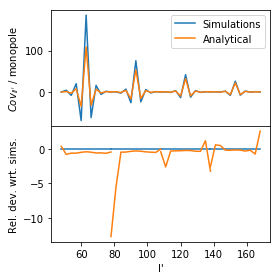

In [23]:
chi2_TBTB, corr_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovTh_TBTB[:lmax, :lmax],
                                        modes="TBTB", foutput=foutput + '_TBTB')

## EBEB

Checks for EBEB
Diagonal covariance matrix


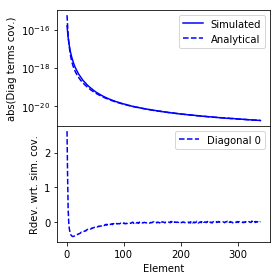

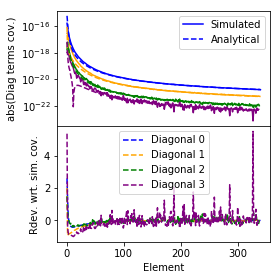

Chi2 distribution check


KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.2925, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005770416017752633, pvalue=0.5182475568989402)
KS between th. and chi2 distributions:  KstestResult(statistic=0.2944234693732546, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.003855246266848522, pvalue=0.9275419013707239)

Difference between analytic and sims. correlation matrix


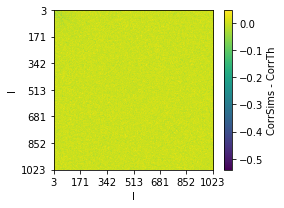

Eigenvalues vs l


Row of cov. matrix.


In [24]:
chi2_EBEB, corr_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovTh_EBEB[:lmax, :lmax],
                                        modes="EBEB", foutput=foutput + '_EBEB')

# Spin0 approximation

In [25]:
foutput = fig_run_path + '_spin0app'

## TTTT

Checks for TTTT
Diagonal covariance matrix


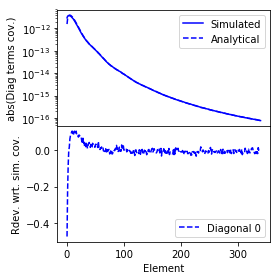

Chi2 distribution check


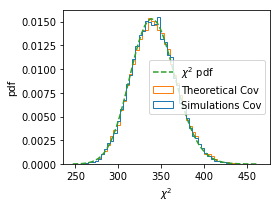

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.012700000000000045, pvalue=0.07882447996853424)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0034251700043310684, pvalue=0.9730599035908839)
KS between th. and chi2 distributions:  KstestResult(statistic=0.01135294882084481, pvalue=0.011534290607229467)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.00725857162221466, pvalue=0.24265260871560915)

Difference between analytic and sims. correlation matrix


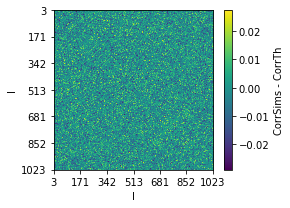

Eigenvalues vs l


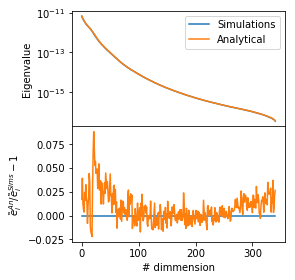

Row of cov. matrix.


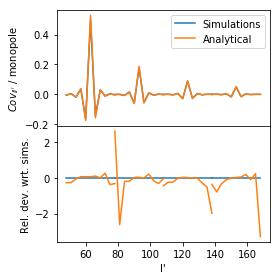

In [26]:
chi20_TTTT, corr0_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovTh0_TT[:lmax, :lmax],
                                          modes="TTTT", foutput=foutput + '_TTTT')

## TETE

Checks for TETE
Diagonal covariance matrix


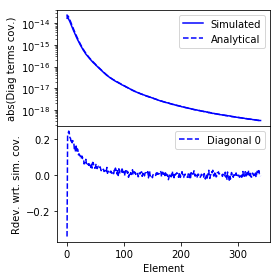

Chi2 distribution check


KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.08605000000000002, pvalue=6.754656372159514e-65)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0037126622554555233, pvalue=0.9456310665942268)
KS between th. and chi2 distributions:  KstestResult(statistic=0.0873667790624083, pvalue=5.047036297262419e-133)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006564449564426367, pvalue=0.3547909427370333)

Difference between analytic and sims. correlation matrix


Eigenvalues vs l


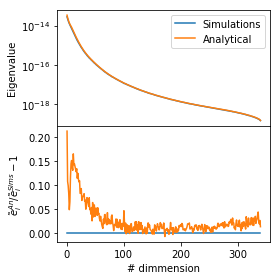

Row of cov. matrix.


In [27]:
chi20_TETE, corr0_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovTh0_TE[:lmax, :lmax],
                                          modes="TETE", foutput=foutput + '_TETE')

## EEEE

Checks for EEEE
Diagonal covariance matrix


Chi2 distribution check


KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.17159999999999997, pvalue=8.158505752629481e-257)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006154739083174987, pvalue=0.43485208807263914)
KS between th. and chi2 distributions:  KstestResult(statistic=0.17348198450498226, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005991990626859955, pvalue=0.46928458859190914)

Difference between analytic and sims. correlation matrix


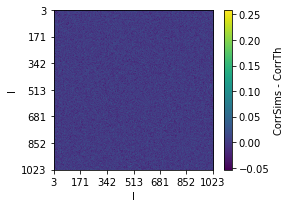

Eigenvalues vs l


Row of cov. matrix.


In [28]:
chi20_EEEE, corr0_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovTh0_EE[:lmax, :lmax],
                                          modes="EEEE", foutput=foutput + '_EEEE')

## BBBB

Checks for BBBB
Diagonal covariance matrix


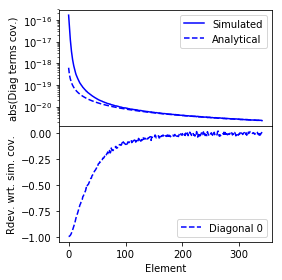

Chi2 distribution check


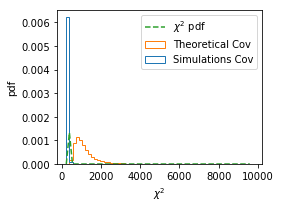

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.99925, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004675605849221831, pvalue=0.7744163258682204)
KS between th. and chi2 distributions:  KstestResult(statistic=0.999188258674156, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006843085681410566, pvalue=0.306174828140944)

Difference between analytic and sims. correlation matrix


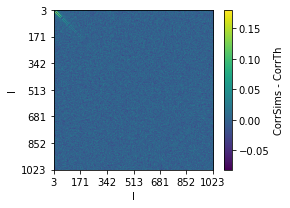

Eigenvalues vs l


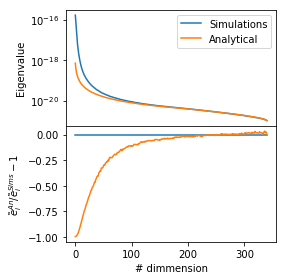

Row of cov. matrix.


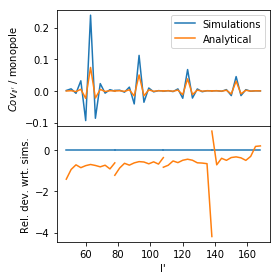

In [29]:
chi20_BBBB, corr0_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovTh0_BB[:lmax, :lmax],
                                          modes="BBBB", foutput=foutput + '_BBBB')

## TBTB

Checks for TBTB
Diagonal covariance matrix


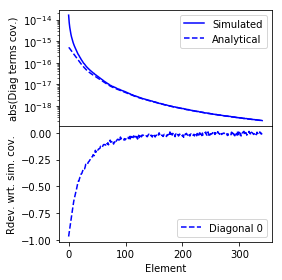

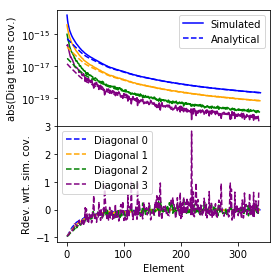

Chi2 distribution check


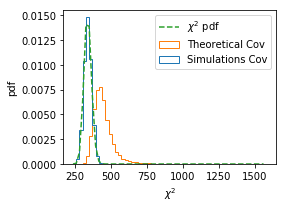

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.81355, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004246749950455098, pvalue=0.8635123463492754)
KS between th. and chi2 distributions:  KstestResult(statistic=0.8112463760568932, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0039656349329938445, pvalue=0.911534071640533)

Difference between analytic and sims. correlation matrix


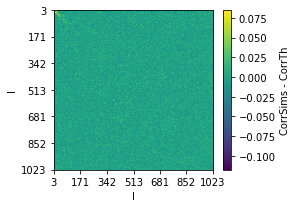

Eigenvalues vs l


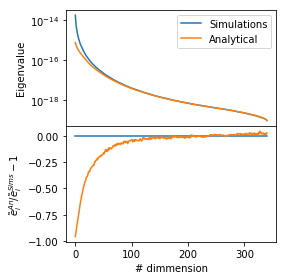

Row of cov. matrix.


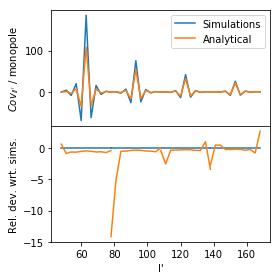

In [30]:
chi20_TBTB, corr0_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovTh0_TB[:lmax, :lmax],
                                          modes="TBTB", foutput=foutput + '_TBTB')

## EBEB

Checks for EBEB
Diagonal covariance matrix


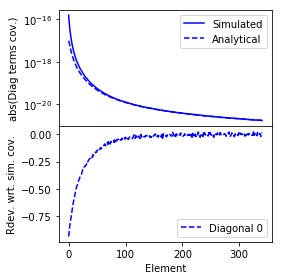

Chi2 distribution check


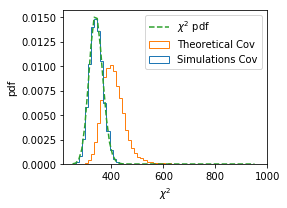

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.6899000000000001, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005770416017752633, pvalue=0.5182475568989402)
KS between th. and chi2 distributions:  KstestResult(statistic=0.6877925504060415, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.008897180770984225, pvalue=0.08430443864443762)

Difference between analytic and sims. correlation matrix


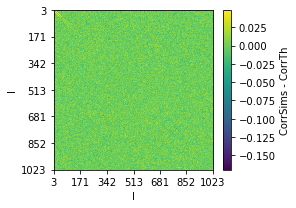

Eigenvalues vs l


Row of cov. matrix.


In [31]:
chi20_EBEB, corr0_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovTh0_EB[:lmax, :lmax],
                                          modes="EBEB", foutput=foutput + '_EBEB')

# Naive approximation

In [32]:
foutput = fig_run_path + '_naive'

## TTTT

In [33]:
lTh[-1], len(clTh_TT)

(29999, 30000)

Checks for TTTT
Diagonal covariance matrix


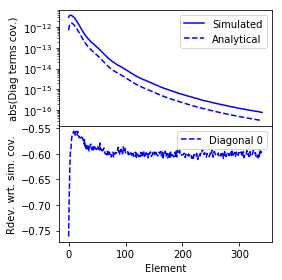

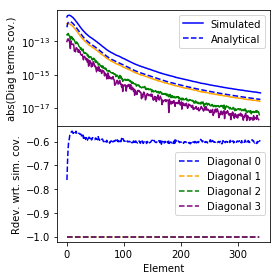

Chi2 distribution check


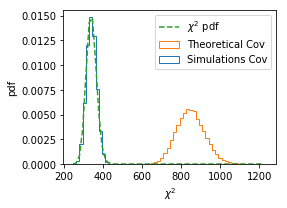

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0034251700043310684, pvalue=0.9730599035908839)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9999999999999999, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005658986620955764, pvalue=0.5436518396933807)

Difference between analytic and sims. correlation matrix


Eigenvalues vs l


Row of cov. matrix.


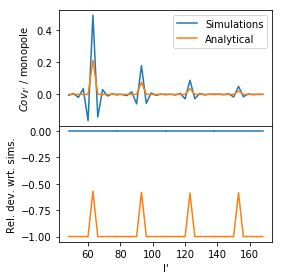

In [34]:
chi2N_TTTT, corr2N_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovThN_TT[:lmax, :lmax],
                                           modes="TTTT", foutput=foutput + '_TTTT')

## TETE

Checks for TETE
Diagonal covariance matrix


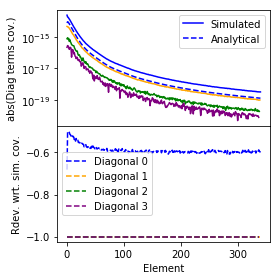

Chi2 distribution check


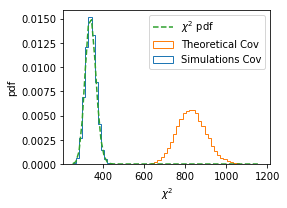

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0037126622554555233, pvalue=0.9456310665942268)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9999999999999702, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0034633338473690767, pvalue=0.9701024859409646)

Difference between analytic and sims. correlation matrix


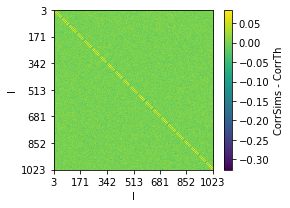

Eigenvalues vs l


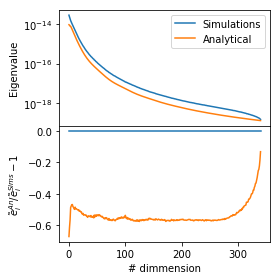

Row of cov. matrix.


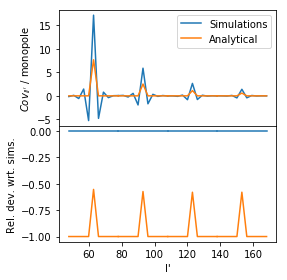

In [35]:
chi2N_TETE, corrN_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovThN_TE[:lmax, :lmax],
                                          modes="TETE", foutput=foutput + '_TETE')

## EEEE

Checks for EEEE
Diagonal covariance matrix


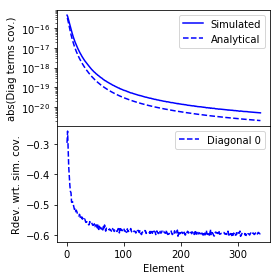

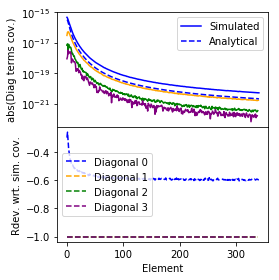

Chi2 distribution check


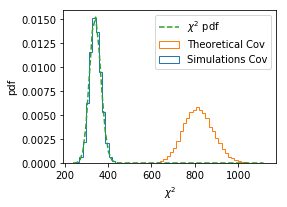

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006154739083174987, pvalue=0.43485208807263914)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9999999999999514, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.007805817013296079, pvalue=0.17468832477749183)

Difference between analytic and sims. correlation matrix


Eigenvalues vs l


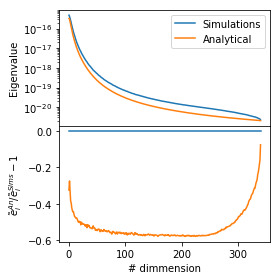

Row of cov. matrix.


In [36]:
chi2N_EEEE, corrN_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovThN_EE[:lmax, :lmax],
                                          modes="EEEE", foutput=foutput + '_EEEE')

## BBBB

## TBTB

Checks for BBBB
Diagonal covariance matrix


Chi2 distribution check


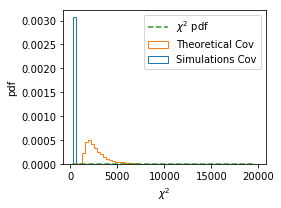

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004675605849221831, pvalue=0.7744163258682204)
KS between th. and chi2 distributions:  KstestResult(statistic=1.0, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0055016673997208, pvalue=0.5802263783382537)

Difference between analytic and sims. correlation matrix


Eigenvalues vs l


Row of cov. matrix.


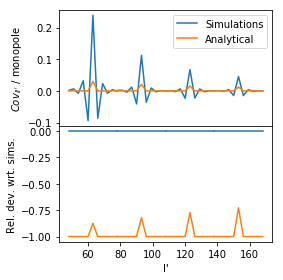

In [37]:
chi2N_BBBB, corrN_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovThN_BB[:lmax, :lmax],
                                          modes="BBBB", foutput=foutput + '_BBBB')

Checks for TBTB
Diagonal covariance matrix


Chi2 distribution check


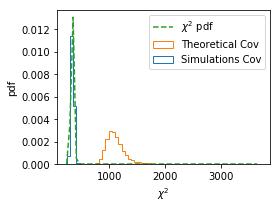

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004246749950455098, pvalue=0.8635123463492754)
KS between th. and chi2 distributions:  KstestResult(statistic=1.0, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005355828242043503, pvalue=0.6146761330333604)

Difference between analytic and sims. correlation matrix


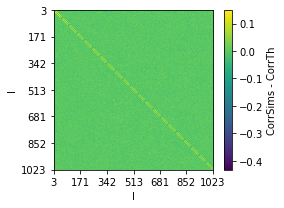

Eigenvalues vs l


Row of cov. matrix.


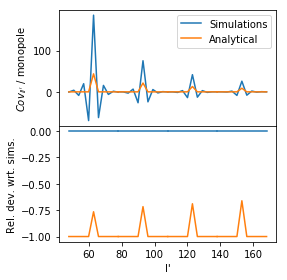

In [38]:
chi2N_TBTB, corr_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovThN_TB[:lmax, :lmax],
                                         modes="TBTB", foutput=foutput + '_TBTB')

## EBEB

Checks for EBEB
Diagonal covariance matrix


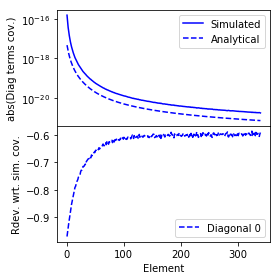

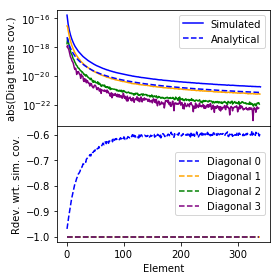

Chi2 distribution check


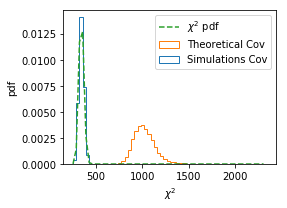

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005770416017752633, pvalue=0.5182475568989402)
KS between th. and chi2 distributions:  KstestResult(statistic=1.0, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.008332068212351551, pvalue=0.1244279737654273)

Difference between analytic and sims. correlation matrix


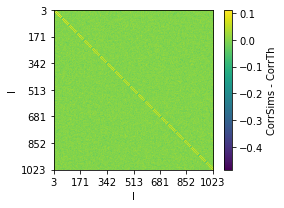

Eigenvalues vs l


Row of cov. matrix.


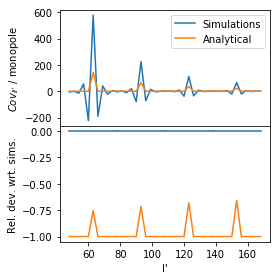

In [39]:
chi2N_EBEB, corrN_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovThN_EB[:lmax, :lmax],
                                          modes="EBEB", foutput=foutput + '_EBEB')

# Comparing the approximations

In [40]:
foutput = fig_run_path + '_ALL'

## Diagonal & eigenvalues & row cov

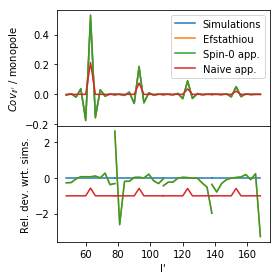

In [41]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TT[:lmax,:lmax], [CovTh_TT[:lmax,:lmax], CovTh0_TT[:lmax,:lmax], CovThN_TT[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTT,axis=0)[0]**2,
                             principal=False, foutput=foutput + '_TTTT')

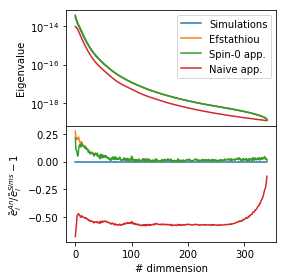

In [42]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TE[:lmax,:lmax], [CovTh_TE[:lmax,:lmax], CovTh0_TE[:lmax,:lmax], CovThN_TE[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTE,axis=0)[0]**2,
                             foutput=foutput + '_TETE')

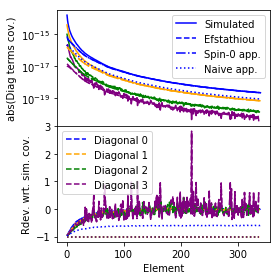

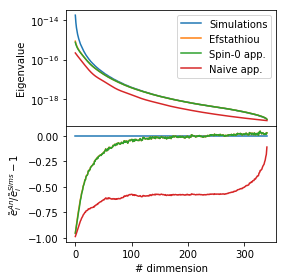

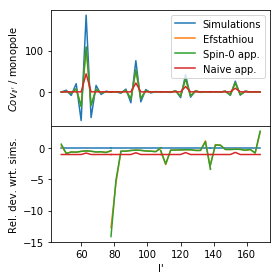

In [43]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TB[:lmax,:lmax], [CovTh_TB[:lmax,:lmax], CovTh0_TB[:lmax,:lmax], CovThN_TB[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB, axis=0)[0]**2,
                             foutput=foutput + '_TBTB')

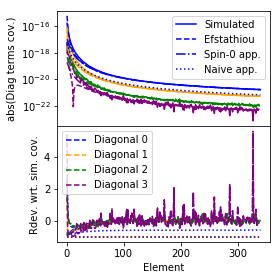

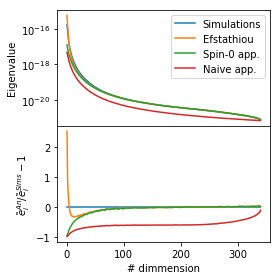

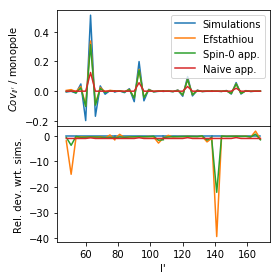

In [44]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_EB[:lmax,:lmax], [CovTh_EB[:lmax,:lmax], CovTh0_EB[:lmax,:lmax], CovThN_EB[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB,axis=0)[0]**2,
                             foutput=foutput + '_EBEB')

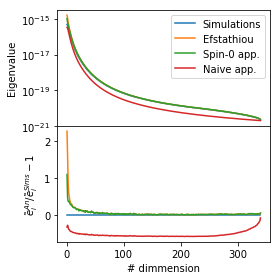

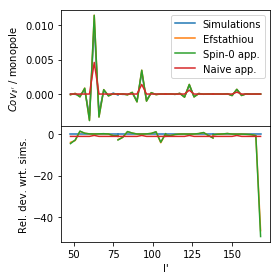

In [45]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_EE[:lmax,:lmax], [CovTh_EE[:lmax,:lmax], CovTh0_EE[:lmax,:lmax], CovThN_EE[:lmax,:lmax]], 
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clEE,axis=0)[0]**2,
                            foutput=foutput + '_EEEE')

In [46]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_BB[:lmax,:lmax], [CovTh_BB[:lmax,:lmax], CovTh0_BB[:lmax,:lmax], CovThN_BB[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clBB,axis=0)[0]**2,
                             principal=False, foutput=foutput + '_BBBB')

## $\chi^2$

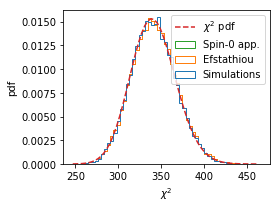

In [47]:
co.plot_chi2([chi2_TTTT[0], chi2_TTTT[1], chi20_TTTT[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_TTTT')

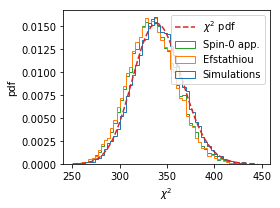

In [48]:
co.plot_chi2([chi2_TETE[0], chi2_TETE[1], chi20_TETE[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_TETE')

In [49]:
co.plot_chi2([chi2_TBTB[0], chi2_TBTB[1], chi20_TBTB[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_TBTB')

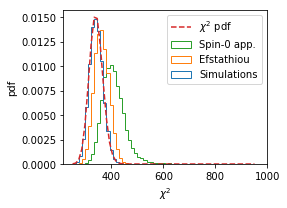

In [50]:
co.plot_chi2([chi2_EBEB[0], chi2_EBEB[1], chi20_EBEB[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_EBEB')

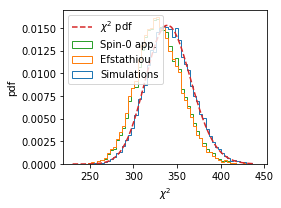

In [51]:
co.plot_chi2([chi2_EEEE[0], chi2_EEEE[1], chi20_EEEE[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_EEEE')

In [52]:
co.plot_chi2([chi2_BBBB[0], chi2_BBBB[1], chi20_BBBB[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_BBBB')

In [53]:
co.plot_chi2([chi2_BBBB[0], chi20_BBBB[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_BBBB')

## Covariance rows

In [54]:
li = 20
for i in range(5):
    X = lbins[:lmax][li-5:li+6]
    #Y = CovSims_TT[li, li-5:li+5]/clTT[0, li-5:li+5]**2
    Y = CovSims_TT[:lmax,:lmax][li, li-5:li+6]/clTT[0, 0]**2
    Yth = CovTh_TT[:lmax,:lmax][li, li-5:li+6]/clTT[0, 0]**2

    li += 2*5

    plt.plot(X, Y, c='blue')
    plt.plot(X, Yth, c='orange')
    
plt.show()
plt.close()

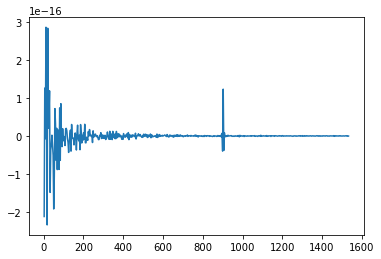

In [55]:
plt.plot(lbins, CovSims_TT[300])
plt.show()

# Super Cov-TTEEEE

In [56]:
foutput = fig_run_path + '_Efstathiou'

In [57]:
clTT[:15000].T.shape

(511, 15000)

In [58]:
# CovSims_path = run_path + '_covLess'+sims_suffix
# if os.path.isfile(CovSims_path):
#     C = np.load(CovSims_path)['arr_0']
# else:
#     C = np.cov(np.concatenate([clTT[:15000].T, clTE[:15000].T, clTB[:15000].T, clEE[:15000].T, clEB[:15000].T, clBB[:15000].T]))
#     np.savez_compressed(CovSims_path, C)
# C = C.reshape((6, nlbins, 6, nlbins))

# CovSims_TT = C[0, :, 0, :]
# CovSims_TE = C[1, :, 1, :]
# CovSims_TB = C[2, :, 2, :]
# CovSims_EE = C[3, :, 3, :]
# CovSims_EB = C[4, :, 4, :]
# CovSims_BB = C[5, :, 5, :]

# CovSims_TTTE = C[0, :, 1, :]
# CovSims_TTTB = C[0, :, 2, :]
# CovSims_TTEE = C[0, :, 3, :]
# CovSims_TTEB = C[0, :, 4, :]
# CovSims_TTBB = C[0, :, 4, :]

# CovSims_TETB = C[1, :, 2, :]
# CovSims_TEEE = C[1, :, 3, :]
# CovSims_TEEB = C[1, :, 4, :]
# CovSims_TEBB = C[1, :, 5, :]

# CovSims_TBEE = C[2, :, 3, :]
# CovSims_TBEB = C[2, :, 4, :]
# CovSims_TBBB = C[2, :, 5, :]

# CovSims_EEEB = C[3, :, 4, :]
# CovSims_EEBB = C[3, :, 5, :]

# CovSims_EBBB = C[4, :, 5, :]

In [59]:
CovSims_path = run_path + '_covTTTEE_b1_short'+sims_suffix
CovTh_path = run_path + '_covThTTTEEE_b1_short.npz'

if os.path.isfile(CovSims_path):
    CovSims_TTTEEE_short = np.load(CovSims_path)['arr_0']
else:
    CovSims_TTTEEE_short =  np.block([[CovSims_TT[:lmax, :lmax], CovSims_TTTE[:lmax, :lmax], CovSims_TTEE[:lmax, :lmax]], 
                            [CovSims_TTTE.T[:lmax, :lmax], CovSims_TE[:lmax, :lmax], CovSims_TEEE[:lmax, :lmax]], 
                            [CovSims_TTEE.T[:lmax, :lmax], CovSims_TEEE.T[:lmax, :lmax], CovSims_EE[:lmax, :lmax]]])
    np.savez_compressed(CovSims_path, CovSims_TTTEEE_short) 

if os.path.isfile(CovTh_path):
    CovTh_TTTEEE_short = np.load(CovTh_path)['arr_0']
else:
    CovTh_TTTEEE_short =  np.block([[CovTh_TT[:lmax, :lmax], CovTh_TTTE[:lmax, :lmax], CovTh_TTEE[:lmax, :lmax]], 
                            [CovTh_TTTE.T[:lmax, :lmax], CovTh_TE[:lmax, :lmax], CovTh_TEEE[:lmax, :lmax]], 
                            [CovTh_TTEE.T[:lmax, :lmax], CovTh_TEEE.T[:lmax, :lmax], CovTh_EE[:lmax, :lmax]]])
    np.savez_compressed(CovTh_path, CovTh_TTTEEE_short) 
    
clTTTEEE = np.concatenate([clTT[:, :lmax], clTE[:, :lmax], clEE[:, :lmax]], axis=1)
# clTTTEEE = np.concatenate([clTT[15000:, :lmax], clTE[15000:, :lmax], clEE[15000:, :lmax]], axis=1)

lbinsTTTEEE = np.concatenate([lbins[:lmax]]*3)

Checks for TTTTEEE
Diagonal covariance matrix


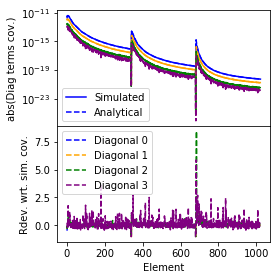

Chi2 distribution check


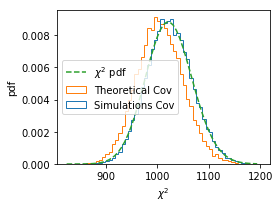

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.16130000000000005, pvalue=5.842175688332251e-227)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005722039266820023, pvalue=0.5292192421839925)
KS between th. and chi2 distributions:  KstestResult(statistic=0.16170808072639797, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.004684031055349369, pvalue=0.7725268147898846)

Difference between analytic and sims. correlation matrix


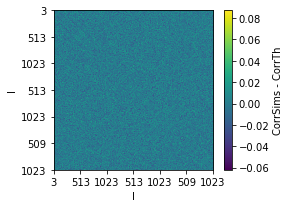

Eigenvalues vs l


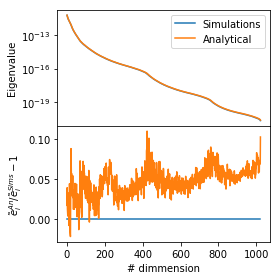

In [60]:
chi2_TTTEEE, corr_TTTEEE = co.do_all_checks(lbinsTTTEEE, clTTTEEE, CovSims_TTTEEE_short, CovTh_TTTEEE_short,
                                            modes="TTTTEEE", row_cov=False,
                                            foutput=foutput + '_TTTEEE')